Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV04 Segmentation

### Lab Description
This laboratory exercise introduces **SegNet**, a convolutional encoder–decoder architecture for **semantic segmentation**. SegNet is widely applied in scene understanding tasks, especially in autonomous driving, where it classifies each pixel of an image into categories (e.g., road, building, car, pedestrian).

In this hands-on lab, you will train a SegNet model on the **CamVid dataset**, record training statistics (time, VRAM, batch size), save logs and checkpoints, and visualize segmentation predictions.



### What you can expect to learn
- **Theoretical Understanding**: Understand encoder–decoder segmentation architectures, pooling indices, and class-wise pixel prediction.
- **Implementation of SegNet**: Build SegNet in PyTorch and train it on CamVid images.
- **Training & Monitoring**: Track per-epoch time, batch size, VRAM usage, and loss values. Save logs (`log.txt`) and checkpoints (`.pth`).
- **Visualization & Evaluation**:  
  - Plot training curves (loss).  
  - Display sample segmentation outputs vs. ground truth.  
  - Report training statistics in a CSV file.  


In [1]:
import sys

import torch
import torchvision

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Python: 3.12.11
PyTorch: 2.8.0+rocm6.4
Torchvision: 0.23.0+rocm6.4
CUDA available: True
CUDA device: AMD Radeon AI PRO R9700


## 1. Import necessary libraries

In [7]:
import glob
import os
import random
import time
import zipfile
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms.functional as TF
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset


@dataclass
class CFG:
    seed: int = 42
    batch_size: int = 8
    epochs: int = 20
    lr: float = 1e-3
    num_classes: int = 32  # CamVid has 32 classes
    img_size: tuple = (256, 256)  # (H, W) resize for training
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


cfg = CFG()

# Base dirs (always under ~/data)
DATA_BASE = os.path.expanduser("~/data")
CAMVID_DIR = os.path.join(DATA_BASE, "CamVid/CamVid/CamVid")
OUTPUT_DIR = os.path.join(DATA_BASE, "segnet_outputs")
os.makedirs(DATA_BASE, exist_ok=True)
os.makedirs(CAMVID_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("DATA_BASE:", DATA_BASE)
print("CAMVID_DIR:", CAMVID_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(cfg.seed)
cfg

DATA_BASE: /home/aup/data
CAMVID_DIR: /home/aup/data/CamVid/CamVid/CamVid
OUTPUT_DIR: /home/aup/data/segnet_outputs


CFG(seed=42, batch_size=8, epochs=20, lr=0.001, num_classes=32, img_size=(256, 256), device='cuda')

## 2. Required Dataset
We use the `CamVid` dataset (road scene images, 480×360).

Download from Kaggle page (which already includes official splits):  
https://www.kaggle.com/datasets/carlolepelaars/camvid

Upload `CamVid.zip` to `~/data/` (shown as `/root/data/CamVid.zip`).  
Then run this cell to extract.  
Expected folders after extraction:
- `train/`, `train_labels/`
- `val/`, `val_labels/`
- `test/`, `test_labels/`
- `class_dict.csv`

In [8]:
ZIP_PATH = os.path.join(DATA_BASE, "CamVid.zip")
assert os.path.exists(ZIP_PATH), "❗ Please upload CamVid.zip to ~/data first."

with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(CAMVID_DIR)

print("Extracted top level:", os.listdir(CAMVID_DIR))
for split in ["train", "val", "test"]:
    n_img = len(glob.glob(os.path.join(CAMVID_DIR, split, "*")))
    n_lab = len(glob.glob(os.path.join(CAMVID_DIR, f"{split}_labels", "*")))
    print(f"{split:<5}: {n_img:>4} images | {n_lab:>4} labels")

csv_path = os.path.join(CAMVID_DIR, "class_dict.csv")
print("class_dict.csv exists:", os.path.exists(csv_path))

Extracted top level: ['val', 'train', 'class_dict.csv', 'test', 'test_labels', 'CamVid', 'val_labels', 'train_labels']
train:  369 images |  369 labels
val  :  100 images |  100 labels
test :  232 images |  232 labels
class_dict.csv exists: True


## 2-1. Build Color Map from `class_dict.csv`
CamVid labels are color-encoded PNGs.  
We will:
- read `class_dict.csv` (columns typically include class name and RGB channels),  
- create mappings: **color (R,G,B) → class index**, and **class index → color** for visualization.


In [9]:
csv_path = os.path.join(CAMVID_DIR, "class_dict.csv")
assert os.path.exists(csv_path), "❗ class_dict.csv not found."

# Expecting columns like: 'name','r','g','b' (order may vary, but r/g/b should be present)
cls_df = pd.read_csv(csv_path)
assert {"r", "g", "b"}.issubset(set(cls_df.columns)), "class_dict.csv must have r,g,b columns."

# Build mappings
color2id = {}
id2color = {}
for idx, row in cls_df.reset_index().iterrows():
    r, g, b = int(row["r"]), int(row["g"]), int(row["b"])
    color2id[(r, g, b)] = idx
    id2color[idx] = (r, g, b)

num_classes_in_csv = len(id2color)
print("Classes from CSV:", num_classes_in_csv)
# Keep cfg.num_classes consistent with CSV (prefer CSV count)
cfg = dataclass(type(cfg))(**{**cfg.__dict__, "num_classes": num_classes_in_csv})
cfg

Classes from CSV: 32


CFG(seed=42, batch_size=8, epochs=20, lr=0.001, num_classes=32, img_size=(256, 256), device='cuda')

## 2-2. CamVid Dataset Class
- Reads images and **color masks**.
- Converts color masks → **index masks** with our `color2id` mapping.
- Resizes images with bilinear, masks with nearest (avoid introducing new classes).
- Outputs: `(image_tensor [0,1], mask_long)` where `mask_long` ∈ `[0 .. num_classes-1]`.


In [10]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(256, 256)):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))
        assert len(self.image_paths) == len(self.mask_paths) > 0, "Image/label count mismatch or empty."
        self.size = size

    def _color_to_index(self, mask_rgb: np.ndarray) -> np.ndarray:
        H, W, _ = mask_rgb.shape
        idx = np.zeros((H, W), dtype=np.int64)
        # Vectorized mapping by building a flat view of colors -> tuple keys
        flat = mask_rgb.reshape(-1, 3)
        keys = [tuple(px) for px in flat]
        mapped = [color2id.get(k, 0) for k in keys]  # unknown colors map to 0
        idx = np.array(mapped, dtype=np.int64).reshape(H, W)
        return idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        img = Image.open(self.image_paths[i]).convert("RGB")
        mask_img = Image.open(self.mask_paths[i]).convert("RGB")

        # Resize: image bilinear, mask nearest
        img = TF.resize(img, self.size, interpolation=TF.InterpolationMode.BILINEAR)
        mask_img = TF.resize(mask_img, self.size, interpolation=TF.InterpolationMode.NEAREST)

        img_t = TF.to_tensor(img)  # [C,H,W], float32 in [0,1]
        mask_np = np.array(mask_img, dtype=np.uint8)
        mask_idx = self._color_to_index(mask_np)

        return img_t, torch.from_numpy(mask_idx).long()

## 2-3. DataLoaders (train / val / test)
Create DataLoaders from the official splits provided by Kaggle CamVid.


In [11]:
train_set = CamVidDataset(
    image_dir=os.path.join(CAMVID_DIR, "train"), mask_dir=os.path.join(CAMVID_DIR, "train_labels"), size=cfg.img_size
)
val_set = CamVidDataset(
    image_dir=os.path.join(CAMVID_DIR, "val"), mask_dir=os.path.join(CAMVID_DIR, "val_labels"), size=cfg.img_size
)
test_set = CamVidDataset(
    image_dir=os.path.join(CAMVID_DIR, "test"), mask_dir=os.path.join(CAMVID_DIR, "test_labels"), size=cfg.img_size
)

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)

len(train_set), len(val_set), len(test_set)

(369, 100, 232)

Batch shape: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
Image value range: 0.0 1.0
Mask unique classes in this batch: tensor([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21,
        22, 24, 26, 27, 29, 30, 31])


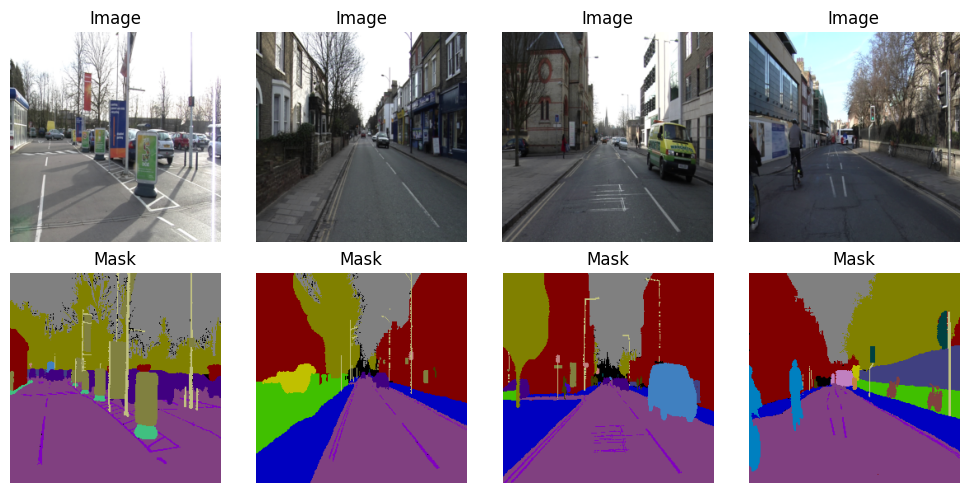

In [12]:
def colorize_mask(idx_mask: np.ndarray) -> Image.Image:
    """Convert index mask → RGB mask using id2color mapping built from class_dict.csv."""
    h, w = idx_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for c, (r, g, b) in id2color.items():
        rgb[idx_mask == c] = (r, g, b)
    return Image.fromarray(rgb)


# Fetch one batch
imgs, masks = next(iter(train_loader))

print("Batch shape:", imgs.shape, masks.shape)
print("Image value range:", imgs.min().item(), imgs.max().item())
print("Mask unique classes in this batch:", torch.unique(masks))

# Show first 4 samples
n_show = min(4, imgs.size(0))
plt.figure(figsize=(10, 5))
for i in range(n_show):
    # Image
    plt.subplot(2, n_show, i + 1)
    plt.imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
    plt.title("Image")
    plt.axis("off")

    # Mask
    plt.subplot(2, n_show, i + 1 + n_show)
    mask_colored = colorize_mask(masks[i].numpy())
    plt.imshow(mask_colored)
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 3. Model: A Compact SegNet
SegNet uses an **encoder–decoder** with **max-pool indices** to upsample in the decoder.  
For pedagogy and speed, we implement **3 down/up stages** (you can extend to 5).


In [13]:
class SegNetSmall(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Encoder: 3 stages
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)

        # Decoder: mirrors encoder, uses MaxUnpool2d with stored indices
        self.unpool3 = nn.MaxUnpool2d(2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 3, padding=1),
        )

    def forward(self, x):
        # encode
        x = self.enc1(x)
        size1 = x.size()
        x, ind1 = self.pool1(x)
        x = self.enc2(x)
        size2 = x.size()
        x, ind2 = self.pool2(x)
        x = self.enc3(x)
        size3 = x.size()
        x, ind3 = self.pool3(x)

        # decode
        x = self.unpool3(x, ind3, output_size=size3)
        x = self.dec3(x)
        x = self.unpool2(x, ind2, output_size=size2)
        x = self.dec2(x)
        x = self.unpool1(x, ind1, output_size=size1)
        x = self.dec1(x)
        return x

## 4. Loss & Optimizer
- Use **CrossEntropyLoss** (expects class indices as targets).  
- Use **Adam** optimizer with LR from config.


In [14]:
device = torch.device(cfg.device)
model = SegNetSmall(cfg.num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

model

SegNetSmall(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

## 5. Training Loop
- Track per-epoch: **time**, **avg loss**, **peak VRAM**.  
- Append to `OUTPUT_DIR/log.txt`.  
- Save **checkpoint per epoch** → `checkpoint_epoch_{N}.pth`.  
- Store lists for **curves** and **final CSV**.


In [28]:
# -------- utils --------
def _cuda_index(dev):
    d = torch.device(dev) if not isinstance(dev, torch.device) else dev
    if d.type != "cuda":
        return None
    return d.index if d.index is not None else torch.cuda.current_device()


def gpu_reset_peaks():
    if torch.cuda.is_available():
        idx = _cuda_index(device)
        if idx is not None:
            torch.cuda.reset_peak_memory_stats(idx)
            torch.cuda.empty_cache()


def get_peak_vram_mb():
    if torch.cuda.is_available():
        idx = _cuda_index(device)
        if idx is not None:
            return torch.cuda.max_memory_allocated(idx) / (1024**2)
    return 0.0


def pick_amp_dtype():
    try:
        if torch.cuda.is_available() and hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported():
            return torch.bfloat16
        return torch.float16
    except Exception:
        return torch.float16


# -------- metrics --------
def accuracy(logits, targets, topk=(1,)):
    with torch.no_grad():
        if logits.dim() == 2:
            maxk = max(topk)
            _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(targets.view(1, -1).expand_as(pred))
            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append((correct_k.mul_(100.0 / targets.size(0))).item())
            return res

        elif logits.dim() == 4:
            N, C, H, W = logits.shape
            maxk = max(topk)
            k_used = min(maxk, C)
            topk_idx = logits.topk(k_used, dim=1, largest=True, sorted=True).indices  # [N,k,H,W]
            tgt = targets.view(N, 1, H, W)

            res = []
            for k in topk:
                kk = min(k, C)
                correct_pix = (topk_idx[:, :kk, :, :] == tgt).any(dim=1).float()  # [N,H,W]
                acc_per_img = correct_pix.view(N, -1).mean(dim=1) * 100.0
                res.append(acc_per_img.mean().item())
            return res

        else:
            raise ValueError("logits dim should be [N,C] or [N,C,H,W]")


# -------- train/val --------
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None, amp_dtype=None):
    model.train()
    running_loss = running_top1 = running_top5 = 0.0
    n_samples = 0

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        use_amp = scaler is not None and amp_dtype is not None
        if use_amp:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples, 100.0 * running_top1 / n_samples, 100.0 * running_top5 / n_samples)


@torch.no_grad()
def validate(model, loader, criterion, device, amp_dtype=None):
    model.eval()
    running_loss = running_top1 = running_top5 = 0.0
    n_samples = 0

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if amp_dtype is not None:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                logits = model(images)
                loss = criterion(logits, targets)
        else:
            logits = model(images)
            loss = criterion(logits, targets)

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples, 100.0 * running_top1 / n_samples, 100.0 * running_top5 / n_samples)

In [29]:
epoch_times, train_losses, peak_vram_per_epoch = [], [], []

log_path = os.path.join(OUTPUT_DIR, "log.txt")
with open(log_path, "w") as f:
    f.write("epoch,batch_size,time(s),loss,peak_vram(MB)\n")

for epoch in range(1, cfg.epochs + 1):
    model.train()
    gpu_reset_peaks()
    t0 = time.perf_counter()

    total_loss, total_pix = 0.0, 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_pix += imgs.size(0)

    if torch.cuda.is_available():
        idx = _cuda_index(device)
        if idx is not None:
            torch.cuda.synchronize(idx)

    elapsed = time.perf_counter() - t0
    epoch_times.append(elapsed)

    peak = get_peak_vram_mb()
    peak_vram_per_epoch.append(peak)

    avg_loss = total_loss / max(1, total_pix)
    train_losses.append(avg_loss)

    msg = f"Epoch {epoch:02d}/{cfg.epochs} | time {elapsed:.2f}s | loss {avg_loss:.4f} | peak VRAM {peak:.1f} MB"
    print(msg)

    with open(log_path, "a") as f:
        f.write(f"{epoch},{cfg.batch_size},{elapsed:.2f},{avg_loss:.4f},{peak:.1f}\n")

    if (epoch + 1) % 10 == 0:
        ckpt_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch + 1}.pth")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
                "cfg": dict(cfg.__dict__),
            },
            ckpt_path,
        )

Epoch 01/20 | time 56.74s | loss 1.1043 | peak VRAM 2397.3 MB
Epoch 02/20 | time 17.84s | loss 0.9969 | peak VRAM 2397.3 MB
Epoch 03/20 | time 17.85s | loss 1.0146 | peak VRAM 2397.3 MB
Epoch 04/20 | time 17.85s | loss 0.8785 | peak VRAM 2397.3 MB
Epoch 05/20 | time 17.82s | loss 0.8244 | peak VRAM 2397.3 MB
Epoch 06/20 | time 17.84s | loss 0.7731 | peak VRAM 2397.3 MB
Epoch 07/20 | time 17.87s | loss 0.7426 | peak VRAM 2397.3 MB
Epoch 08/20 | time 17.80s | loss 0.7373 | peak VRAM 2397.3 MB
Epoch 09/20 | time 17.85s | loss 0.7155 | peak VRAM 2397.3 MB
Epoch 10/20 | time 17.88s | loss 0.7170 | peak VRAM 2397.3 MB
Epoch 11/20 | time 17.88s | loss 0.6603 | peak VRAM 2397.3 MB
Epoch 12/20 | time 17.87s | loss 0.6199 | peak VRAM 2397.3 MB
Epoch 13/20 | time 17.89s | loss 0.6058 | peak VRAM 2397.3 MB
Epoch 14/20 | time 17.83s | loss 0.5804 | peak VRAM 2397.3 MB
Epoch 15/20 | time 17.87s | loss 0.6429 | peak VRAM 2397.3 MB
Epoch 16/20 | time 17.90s | loss 0.5643 | peak VRAM 2397.3 MB
Epoch 17

## 6. Training Curve
Plot simple curves to verify training direction.


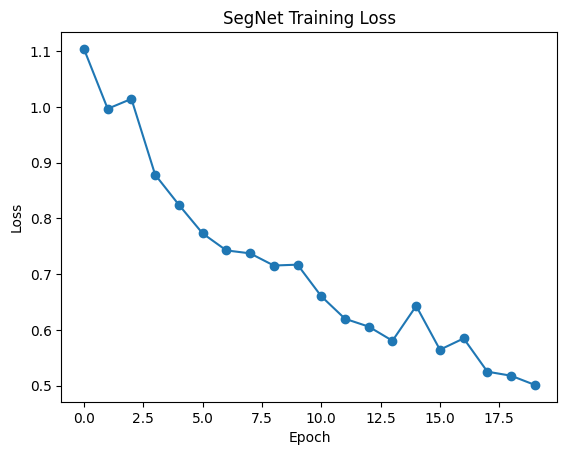

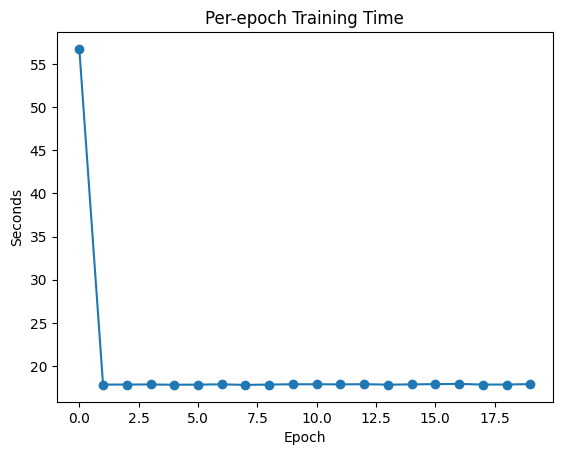

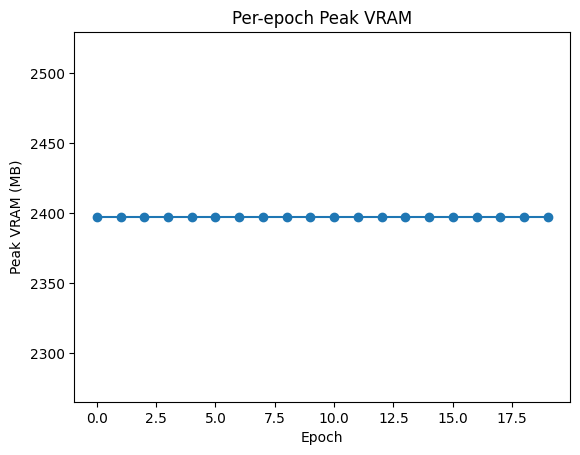

In [30]:
plt.figure()
plt.plot(train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SegNet Training Loss")
plt.show()

plt.figure()
plt.plot(epoch_times, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Seconds")
plt.title("Per-epoch Training Time")
plt.show()

plt.figure()
plt.plot(peak_vram_per_epoch, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Peak VRAM (MB)")
plt.title("Per-epoch Peak VRAM")
plt.show()

## 7. Visualization — Predictions vs. Ground Truth
- Take a mini-batch from **val_loader**.  
- Show **image**, **ground truth (color)**, **prediction (color)**.  
- Use `id2color` to colorize index masks for visualization.


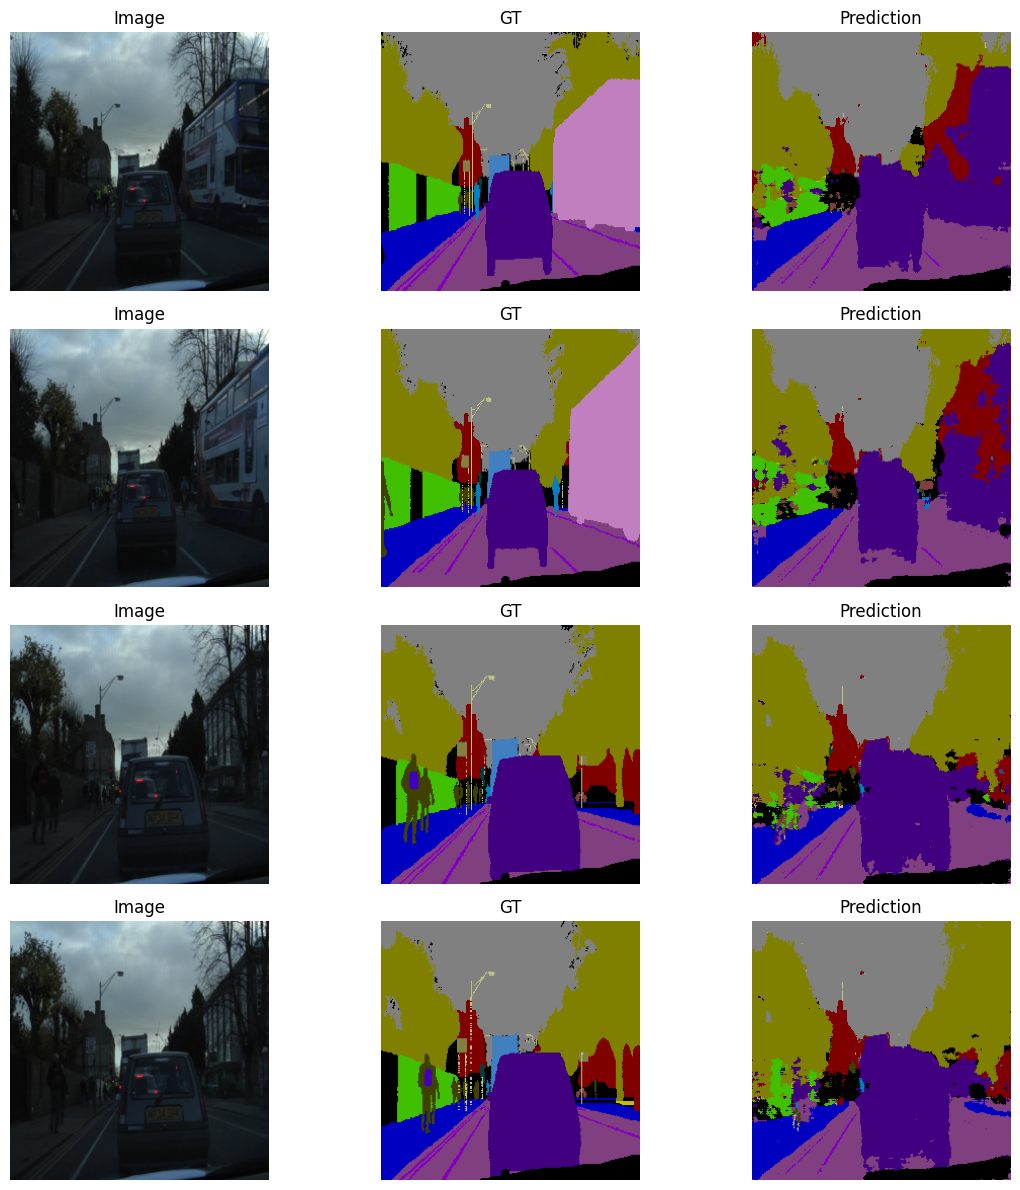

In [31]:
def colorize_mask(idx_mask: np.ndarray) -> Image.Image:
    """Map class indices -> RGB image using id2color."""
    h, w = idx_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for c, (r, g, b) in id2color.items():
        rgb[idx_mask == c] = (r, g, b)
    return Image.fromarray(rgb)


model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    logits = model(imgs)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    gts = masks.numpy()
    ims = imgs.cpu().numpy()

# Show first 4 samples
n_show = min(4, ims.shape[0])
plt.figure(figsize=(12, 3 * n_show))
for i in range(n_show):
    # Image
    plt.subplot(n_show, 3, 3 * i + 1)
    plt.imshow(np.transpose(ims[i], (1, 2, 0)))
    plt.title("Image")
    plt.axis("off")

    # GT (colored)
    plt.subplot(n_show, 3, 3 * i + 2)
    plt.imshow(colorize_mask(gts[i]))
    plt.title("GT")
    plt.axis("off")

    # Pred (colored)
    plt.subplot(n_show, 3, 3 * i + 3)
    plt.imshow(colorize_mask(preds[i]))
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()